In [12]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats
import numpy as np

# Выгрузим данные из базы в датафрейм:

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
SELECT
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    sum(likes) over (partition by exp_group) as group_likes,
    sum(views) over (partition by exp_group) as group_views
FROM {db}.feed_actions 
WHERE
toDate(time) BETWEEN '2022-06-13' AND '2022-06-19'
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

df['ctr'] = df['likes'] / df['views']

df['ctr_control'] = df['group_likes'] / df['group_views']

df['linearized_likes'] = df['likes'] - df['ctr_control'] * df['views']

In [14]:
# Сравниваем группы 0 и 3 t-тестом по линеаризованным лайкам:

print(stats.ttest_ind(df[df.exp_group == 0].linearized_likes,
                df[df.exp_group == 3].linearized_likes,
                equal_var=False))

Ttest_indResult(statistic=-1.422730641028824e-15, pvalue=0.9999999999999989)


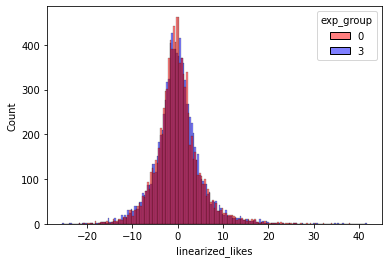

In [24]:
# Для наглядности построим гистограмму:

groups = sns.histplot(data = df[ (df.exp_group == 0) | (df.exp_group == 3) ], 
              x='linearized_likes', 
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

_p-value получился значительно больше, чем в прошлых экспериментах, и мы принимаем гипотезу о равенстве средних линеаризированных лайков в группах 0 и 3._

In [27]:
# Сравниваем группы 1 и 2 t-тестом по линеаризованным лайкам:

print(stats.ttest_ind(df[df.exp_group == 1].linearized_likes,
                df[df.exp_group == 2].linearized_likes,
                equal_var=False))

Ttest_indResult(statistic=-7.296539291600762e-15, pvalue=0.9999999999999942)


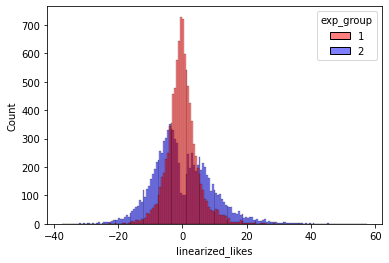

In [25]:
# Для наглядности построим гистограмму:

groups = sns.histplot(data = df[ (df.exp_group == 1) | (df.exp_group == 2) ], 
              x='linearized_likes', 
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

_p-value получился значительно больше, чем в наших прошлых экспериментах, и мы можем принять гипотезу о равенстве средних линеаризированных лайков в группах 1 и 2. Однако из-за особенности распределения по группе 2, которое визуально отличается от нормального, мы не вполне можем доверять этому t-тесту. Поэтому прежде чем делать выводы о схожести групп, стоит провести дополнительные тесты для их сравнения._